In [1]:
%load_ext autoreload

import sys
import os
import csv
import numpy as np
import pandas as pd

from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier

sys.path.append('../../src/')
from propythia.sequence import ReadSequence
from propythia.descriptors import Descriptor
from propythia.preprocess import Preprocess
from propythia.feature_selection import FeatureSelection
from propythia.deep_ml import DeepML

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _E

In [2]:
from propythia.shallow_ml import ShallowML

In [3]:
ar_feat = pd.read_csv('real_datasets/ar_feat.csv')
non_ar_feat = pd.read_csv('real_datasets/non_ar_feat.csv')

In [4]:
ar_feat['label'] = 1
non_ar_feat['label'] = 0

print(ar_feat.shape)
print(non_ar_feat.shape)

ar_feat.to_csv('real_datasets/ar_feat.csv', index = False)
non_ar_feat.to_csv('real_datasets/non_ar_feat.csv', index = False)

(4656, 642)
(13968, 642)


In [5]:
dataset = pd.concat([ar_feat, non_ar_feat])
dataset = dataset.sample(frac=1)
fps_y = dataset['label']
fps_x = dataset.loc[:, dataset.columns != 'label']
fps_x = fps_x.filter(regex=r'_.+D\d', axis=1)  # select just CTD D feature 105 columns
print(fps_x.shape)

(18624, 105)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(fps_x, fps_y, stratify=fps_y)

# standard scaler article does not refer scaling and do not validate in x_test, however, we do it anyway
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# open a ShallowML object
ml = ShallowML(X_train, X_test, y_train, y_test, report_name=None, columns_names=fps_x.columns)
#define param grid as article, here we will search in 100, 200 and 500 estimators
param_grid = [{'clf__n_estimators': [100], 'clf__max_features': ['sqrt']}]
# train_best_model will perform a GRIDSEARCHCV optimizing MCC with a cv = 10
best_rf_model = ml.train_best_model(model_name = 'rf',model='rf', score=make_scorer(matthews_corrcoef), param_grid=param_grid, cv=10)

performing gridSearch...
GridSearchCV took 39.29 seconds for 1 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=10,
             param_grid=[{'clf__max_features': ['sqrt'],
                          'clf__n_estimators': [100]}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.943 (std: 0.013)
 Parameters: {'clf__max_features': 'sqrt', 'clf__n_estimators': 100}
 

make_scorer(matthews_corrcoef)
10
Best score (scorer: make_scorer(matthews_corrcoef)) and parameters from a 10-fold cross validation:
 MCC score:	0.943
 Parameters:	{'clf__max_features': 'sqrt', 'clf__n_estimators': 100}

0.942749 (0.012616) with: {'clf__max_features': 'sqrt', 'clf__n_estimators': 100}
  clf__max_features  clf__n_estimators     means      stds
0              s

In [7]:
#get the scores for testset
scores, report, cm, cm2 = ml.score_testset(best_rf_model)
print(report)
print(cm)
scores

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3492
           1       1.00      0.91      0.95      1164

    accuracy                           0.98      4656
   macro avg       0.98      0.95      0.97      4656
weighted avg       0.98      0.98      0.98      4656

[[3490    2]
 [ 105 1059]]


{'Accuracy': 0.9770189003436426,
 'MCC': 0.9385900867750211,
 'log_loss': 0.09947938003984533,
 'f1 score': 0.9519101123595506,
 'roc_auc': 0.9546105383734249,
 'Precision': array([0.25      , 0.99811499, 1.        ]),
 'Recall': array([1.        , 0.90979381, 0.        ]),
 'fdr': 0.001885014137606032,
 'sn': 0.9097938144329897,
 'sp': 0.9994272623138603}

In [8]:
'''
# multiple metrics
def sp(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fdr = float(fp) / (tp + fp)
    sn = float(tp) / (tp + fn)
    sp = float(tn) / (tn + fp)
    return sp


def sn(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fdr = float(fp) / (tp + fp)
    sn = float(tp) / (tp + fn)
    sp = float(tn) / (tn + fp)
    return sn

#define multiple metrcs to evaluate cross validation
scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'MCC': make_scorer(matthews_corrcoef),
           'sn': make_scorer(sn), 'sp': make_scorer(sp)}

#scaling the data. here, we will use all the data, and not divide in train and test set
scaler_d = StandardScaler().fit_transform(fps_x)

#ml = ShallowML(x_train=scaler_d, x_test=None, y_train=fps_y, y_test=None, report_name=None, columns_names=fps_x.columns)
scores = ml.cross_val_score_model(model_name = 'rf',model='rf', score=scoring, n_estimators=100, max_features='sqrt', cv=10, random_state=65)
pd.DataFrame(scores)
'''

"\n# multiple metrics\ndef sp(y_test, y_pred):\n    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()\n    fdr = float(fp) / (tp + fp)\n    sn = float(tp) / (tp + fn)\n    sp = float(tn) / (tn + fp)\n    return sp\n\n\ndef sn(y_test, y_pred):\n    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()\n    fdr = float(fp) / (tp + fp)\n    sn = float(tp) / (tp + fn)\n    sp = float(tn) / (tn + fp)\n    return sn\n\n#define multiple metrcs to evaluate cross validation\nscoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'MCC': make_scorer(matthews_corrcoef),\n           'sn': make_scorer(sn), 'sp': make_scorer(sp)}\n\n#scaling the data. here, we will use all the data, and not divide in train and test set\nscaler_d = StandardScaler().fit_transform(fps_x)\n\n#ml = ShallowML(x_train=scaler_d, x_test=None, y_train=fps_y, y_test=None, report_name=None, columns_names=fps_x.columns)\nscores = ml.cross_val_score_model(model_name = 'rf',model='rf', score=scoring, n_estimators=100, max

Model not supported, please choose between 'svm', 'sgd', 'linear_svm', 'lr', 'rf' or 'gboosting'
sORCEREY IS THIS
FUCK THIS SHIT


AttributeError: 'str' object has no attribute 'plot'

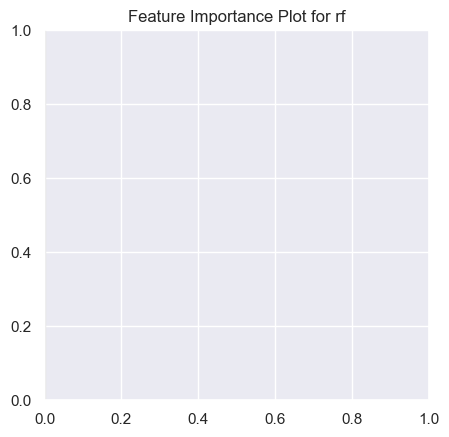

In [12]:
df = ml.features_importances_df(classifier=best_rf_model, model_name = ['rf','svm,gboosting,svg'], top_features=30,column_to_sort='mean_coef')

ml.features_importances_plot(classifier=best_rf_model, top_features=30, model_name='rf',
                             column_to_plot=None,
                             show=True, path_save=None,
                             title=None,
                             kind='barh', figsize=(9, 7), color='r', edgecolor='black',model = 'rf')
#df[:30]



In [10]:
df

In [11]:
ar_data = pd.read_csv('real_datasets/ar_feat.csv')
#AMP_data = AMP_data.drop({'Unnamed: 0'}, axis=1)
ar_data['label'] = 1
non_ar_data = pd.read_csv('real_datasets/non_ar_feat.csv')
non_ar_data['label'] = 0

dataset = pd.concat([ar_data, non_ar_data])  # (13072, 642)
dataset = dataset.sample(frac = 1)
